In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA

from discopy.grammar import Word
from discopy.rigid import Cup, Id, Ty
import torch
import random

from sentence_transformers import SentenceTransformer

from lambeq import LossFunction, PennyLaneModel, PytorchTrainer, QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss, Dataset, AtomicType, IQPAnsatz, BobcatParser, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz
from lambeq.pregroups import remove_cups

import jax.numpy as jnp
import jax
jax.devices()

[CpuDevice(id=0)]

# Get Models Data

In [18]:
import os
import joblib
import numpy as np

color_map = {
    'random': 'Greys', 
    'pca': 'YlGnBu',
    'kpca':  'Blues',
    'svd':  'BuGn',
    'mds':  'Oranges',
    'isomap':  'Reds',
    'constant_0.5':  'copper_r',  
    'constant_0':  'YlOrBr',  
    'constant_1':  'hot_r', 
    'normal_SBERT':  'cool', 
    'normal_zero':  'spring_r', 
} 

line_color_map = {
    'random': 'black', 
    'pca': 'dodgerblue',
    'kpca': 'navy',
    'svd': 'green',
    'mds': 'orange',
    'isomap': 'red',
    'constant_0.5': 'blueviolet',  
    'constant_0': 'pink',  
    'constant_1': 'brown', 
    'normal_SBERT': 'turquoise', 
    'normal_zero': 'orange', 
}

iqp_custom_params = {
    ('1', '1', '1'): {'xlim': (0.04, 0.15), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('1', '2', '1'): {'xlim': (0.04, 0.15), 'ylim': (0.00, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '1'): {'xlim': (0.06, 0.16), 'ylim': (0.00, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '1'): {'xlim': (0.05, 0.155), 'ylim': (0.00, 0.23), 'average_window':0, 'circle_radius': -0.01},

    ('1', '1', '2'): {'xlim': (0.04, 0.135), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('1', '2', '2'): {'xlim': (0.06, 0.14), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '2'): {'xlim': (0.03, 0.15), 'ylim': (0.00, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '2'): {'xlim': (0.04, 0.155), 'ylim': (0.00, 0.23), 'average_window': 0, 'circle_radius': -0.01},

    ('1', '1', '3'): {'xlim': (0.04, 0.135), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('1', '2', '3'): {'xlim': (0.05, 0.16), 'ylim': (0.00, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '3'): {'xlim': (0.06, 0.15), 'ylim': (0.00, 0.22), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '3'): {'xlim': (0.06, 0.155), 'ylim': (0.00, 0.23), 'average_window': 0, 'circle_radius': -0.01},
}

sim14_custom_params = {
    ('1', '1', '1'): {'xlim': (0.07, 0.14), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('1', '2', '1'): {'xlim': (0.085, 0.14), 'ylim': (0.00, 0.22), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '1'): {'xlim': (0.105, 0.145), 'ylim': (0.06, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '1'): {'xlim': (0.1, 0.15), 'ylim': (0.06, 0.23), 'average_window':0, 'circle_radius': -0.01},

    ('1', '1', '2'): {'xlim': (0.063, 0.14), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('1', '2', '2'): {'xlim':(0, 1), 'ylim': (0, 1), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '2'): {'xlim': (0.118, 0.15), 'ylim': (0.10, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '2'): {'xlim': (0, 1), 'ylim': (0, 1), 'average_window': 0, 'circle_radius': -0.01},

    ('1', '1', '3'): {'xlim': (0.076, 0.135), 'ylim': (0.00, 0.21), 'average_window':0, 'circle_radius': -0.01},
    ('1', '2', '3'): {'xlim': (0.08, 0.145), 'ylim': (0.00, 0.22), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '3'): {'xlim': (0.115, 0.147), 'ylim': (0.08, 0.215), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '3'): {'xlim': (0.1195, 0.145), 'ylim': (0.095, 0.215), 'average_window': 0, 'circle_radius': -0.01},
}

sim15_custom_params = {
    ('1', '1', '1'): {'xlim': (0.04, 0.14), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('1', '2', '1'): {'xlim': (0.04, 0.145), 'ylim': (0.00, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '1'): {'xlim': (0.09, 0.145), 'ylim': (0.05, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '1'): {'xlim': (0.105, 0.145), 'ylim': (0.05, 0.23), 'average_window':0, 'circle_radius': -0.01},

    ('1', '1', '2'): {'xlim': (0.08, 0.145), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('1', '2', '2'): {'xlim': (0.09, 0.14), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '2'): {'xlim': (0.1, 0.15), 'ylim': (0.05, 0.23), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '2'): {'xlim': (0.12, 0.145), 'ylim': (0.1, 0.23), 'average_window': 0, 'circle_radius': -0.01},

    ('1', '1', '3'): {'xlim': (0.07, 0.14), 'ylim': (0.00, 0.21), 'average_window':0, 'circle_radius': -0.01},
    ('1', '2', '3'): {'xlim': (0.09, 0.14), 'ylim': (0.00, 0.21), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '1', '3'): {'xlim': (0.1, 0.15), 'ylim': (0.08, 0.22), 'average_window': 0, 'circle_radius': -0.01},
    ('2', '2', '3'): {'xlim': (0.12, 0.145), 'ylim': (0.10, 0.23), 'average_window': 0, 'circle_radius': -0.01},
}

custom_params = {
    "iqp":iqp_custom_params,
    "sim14":sim14_custom_params,
    "sim15":sim15_custom_params,
    }

s_values = ['1', '2']
n_values = ['1', '2']
layers_values = ['1', '2', '3']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w if w > 0 else x

def extract_models_with_parameters(parameters_dict, source_of_models):
    extracted_models = []
    for model_info in source_of_models:
        if all(model_info[param] in values for param, values in parameters_dict.items()):
            extracted_models.append(model_info)
    return extracted_models

def calc_param_from_ansatz(ansatz, n, s, l):
    n = int(n)
    s = int(s)
    l = int(l)
    if n == 1:
        n_iqp = 3
        n_sim14 = 3
        n_sim15 = 3
    else:
        n_sim14 = 4*n
        n_iqp = n-1
        n_sim15 = 2*n
    if ansatz == 'iqp':
        return l*(2*(n_iqp) + 2*n+s-1)
    if ansatz == 'sim14':
        return l*(n_sim14 + n_sim14 + 4*(2*(n) + s))
    if ansatz == 'sim15':
        return l*(n_sim15 + n_sim15 + 2*(2*(n)+s))
    

def retrieve_model_info(model_folder_path):
    if os.path.exists(model_folder_path):
        model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
        model_params = joblib.load(model_params_filepath)
        
        training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
        validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")
        training_losses = np.load(training_losses_filepath)
        validation_losses = np.load(validation_losses_filepath)
        
        folder_parts = os.path.basename(model_folder_path).split('_')
        model_type = folder_parts[0]
        ansatz_name = folder_parts[1][:-len("ansatz")]
        ansatz_hyperparams_str = [folder_parts[2][1:], folder_parts[3][1:], folder_parts[4][len("layers"):]]
        loss_name = folder_parts[5][:-len("loss")]
        optimizer_name = folder_parts[6][:-len("optimizer")]
        optimizer_hyperparams_str = [folder_parts[7][len("a"):], folder_parts[8][len("c"):], folder_parts[9][len("A"):]]
        num_epochs = int(folder_parts[10][len('epochs'):])
        batch_size = int(folder_parts[11][len('batch'):])
        seed = int(folder_parts[12][len('seed'):])
        model_info = {
            'model_type': model_type,
            'ansatz_name': ansatz_name,
            'ansatz_hyperparams_str': ansatz_hyperparams_str,
            'loss_name': loss_name,
            'optimizer_name': optimizer_name,
            'optimizer_hyperparams_str': optimizer_hyperparams_str,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'seed': seed,
            'model_params': model_params,
            'training_losses': training_losses,
            'validation_losses': validation_losses,}
        return model_info
    return None

def retrieve_all_models_info(models_directory):
    model_info_list = []
    for model_folder in os.listdir(models_directory):
        try:
            model_folder_path = os.path.join(models_directory, model_folder)
            model_info = retrieve_model_info(model_folder_path)
            if model_info:
                model_info_list.append(model_info)
        except:
            pass
    return model_info_list

models_directory = "C:/Users/henry/Desktop/MastersProject/QNLP_MasterWork/models"
all_models_info = retrieve_all_models_info(models_directory)

def retrieve_model_info(model_folder_path):
    if os.path.exists(model_folder_path):
        model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
        model_params = joblib.load(model_params_filepath)
        
        training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
        validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")
        training_losses = np.load(training_losses_filepath)
        validation_losses = np.load(validation_losses_filepath)
        
        folder_parts = os.path.basename(model_folder_path).split('_')
        if folder_parts[0] == 'random':
            folder_parts = ['NONE'] + folder_parts
        if 'uniform' in folder_parts[0]:
            folder_parts = ['NONE'] + folder_parts
        embedding_type = folder_parts[0]
        model_type = folder_parts[1]
        ansatz_name = folder_parts[2][:-len("ansatz")]
        ansatz_hyperparams_str = folder_parts[3][1:], folder_parts[4][1:], folder_parts[5][len("layers"):]
        loss_name = folder_parts[6][:-len("loss")]
        optimizer_name = folder_parts[7][:-len("optimiser")]
        optimizer_hyperparams_str = folder_parts[8][1:], folder_parts[9][1:], folder_parts[10][1:]
        num_epochs = int(folder_parts[11][len('epochs'):])
        batch_size = int(folder_parts[12][len('batch'):])
        seed = int(folder_parts[13][len('seed'):])
        model_info = {
            'model_type': model_type,
            'embedding_type':embedding_type,
            'ansatz_name': ansatz_name,
            'ansatz_hyperparams_str': ansatz_hyperparams_str,
            'loss_name': loss_name,
            'optimizer_name': optimizer_name,
            'optimizer_hyperparams_str': optimizer_hyperparams_str,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'seed': seed,
            'model_params': model_params,
            'training_losses': training_losses,
            'validation_losses': validation_losses,
        }
        return model_info
    return None

def retrieve_all_models_info(models_directory):
    model_info_list = []
    for model_folder in os.listdir(models_directory):

        model_folder_path = os.path.join(models_directory, model_folder)
        model_info = retrieve_model_info(model_folder_path)
        model_info['min_val'] = model_info['validation_losses'].min()
        if model_info:
            model_info_list.append(model_info)
    return model_info_list

models_directory = "C:/Users/henry/Desktop/MastersProject/QNLP_MasterWork/red_dim_models"  # Change this to the actual directory path
all_reduced_models = retrieve_all_models_info(models_directory)


def retrieve_model_info(model_folder_path):
    if os.path.exists(model_folder_path):
        model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
        model_params = joblib.load(model_params_filepath)
        
        training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
        validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")
        training_losses = np.load(training_losses_filepath)
        validation_losses = np.load(validation_losses_filepath)
        
        folder_parts = os.path.basename(model_folder_path).split('_')
        if folder_parts[0] == 'random':
            folder_parts = ['NONE'] + folder_parts
        if 'uniform' in folder_parts[0]:
            folder_parts = ['NONE'] + folder_parts
        embedding_type = folder_parts[0]
        model_type = folder_parts[1]
        ansatz_name = folder_parts[2][:-len("ansatz")]
        ansatz_hyperparams_str = folder_parts[3][1:], folder_parts[4][1:], folder_parts[5][len("layers"):]
        loss_name = folder_parts[6][:-len("loss")]
        optimizer_name = folder_parts[7][:-len("optimiser")]
        optimizer_hyperparams_str = folder_parts[8][1:], folder_parts[9][1:], folder_parts[10][1:]
        num_epochs = int(folder_parts[11][len('epochs'):])
        batch_size = int(folder_parts[12][len('batch'):])
        seed = int(folder_parts[13][len('seed'):])
        model_info = {
            'model_type': model_type,
            'embedding_type':embedding_type,
            'ansatz_name': ansatz_name,
            'ansatz_hyperparams_str': ansatz_hyperparams_str,
            'loss_name': loss_name,
            'optimizer_name': optimizer_name,
            'optimizer_hyperparams_str': optimizer_hyperparams_str,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'seed': seed,
            'model_params': model_params,
            'training_losses': training_losses,
            'validation_losses': validation_losses,
        }
        return model_info
    return None

def retrieve_all_models_info(models_directory):
    model_info_list = []
    for model_folder in os.listdir(models_directory):
        model_folder_path = os.path.join(models_directory, model_folder)
        model_info = retrieve_model_info(model_folder_path)
        model_info['min_val'] = model_info['validation_losses'].min()
        if model_info:
            model_info_list.append(model_info)
    return model_info_list

models_directory = "C:/Users/henry/Desktop/MastersProject/QNLP_MasterWork/random_models"  # Change this to the actual directory path
all_random_models = retrieve_all_models_info(models_directory)

# SPSA optimisation

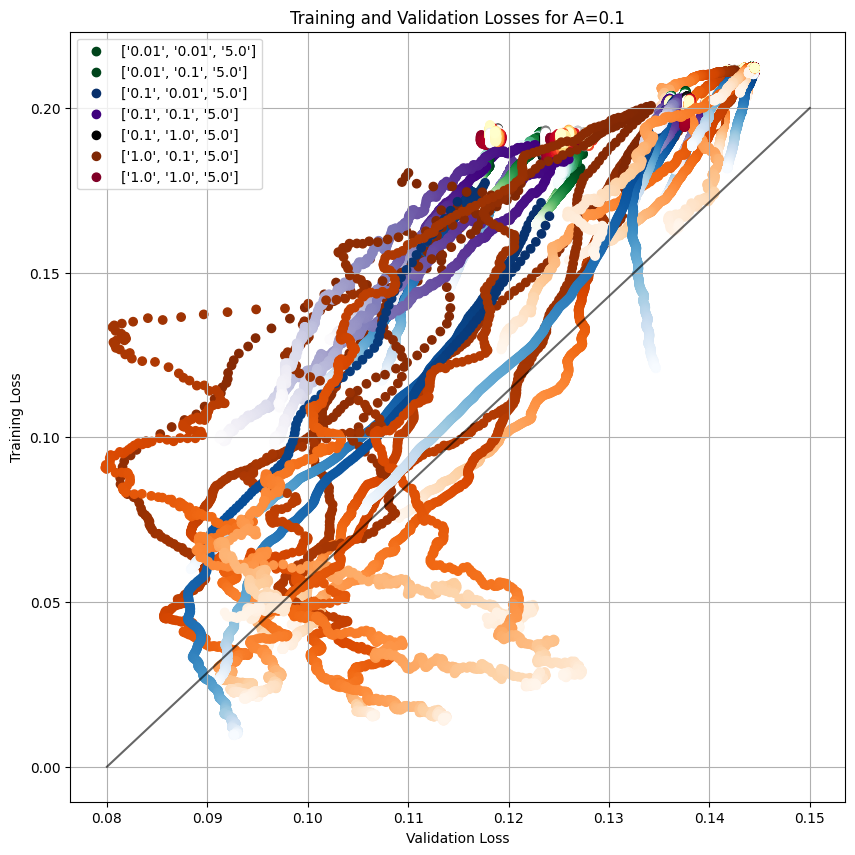

In [28]:
filtered_models = [model_info for model_info in all_models_info]

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

unique_values = [tuple(model_info['optimizer_hyperparams_str']) for model_info in filtered_models]

spsa_color_map = {
    ('0.01', '0.01', '5.0'): 'Greens_r', 
    ('0.01','0.1','5.0'): 'BuGn_r',
    ('0.1','0.01','5.0'):  'Blues_r',
    ('0.1','0.1','5.0'):  'Purples_r',
    ('1.0','0.1','5.0'):  'Oranges_r',
    ('0.1','1.0','5.0'):  'Greys_r',
    ('1.0','1.0','5.0'):  'YlOrRd_r',  
    } 

average_window = 10
fig = plt.figure(figsize=(10, 10))
added_labels = []
# Plot training and validation losses for each model in the filtered_models list
for i, model_info in enumerate(filtered_models):
    num_epochs = model_info['num_epochs']
    training_losses = model_info['training_losses']
    validation_losses = model_info['validation_losses']

    epochs = np.arange(1, num_epochs + 1 - (average_window-1))

    optimizer_param_value = tuple(model_info['optimizer_hyperparams_str'])
    cmap = spsa_color_map.get(optimizer_param_value)
    if cmap is None:
        continue
    iterations_label = model_info['optimizer_hyperparams_str'] if model_info['optimizer_hyperparams_str'] not in added_labels else None
    plt.scatter(moving_average(validation_losses, average_window), moving_average(training_losses, average_window), c=epochs, cmap=cmap, label = iterations_label)
    added_labels.append(model_info['optimizer_hyperparams_str'])

plt.plot([0.08,0.15], [0,0.2], color='k', alpha=0.6)
plt.legend()
plt.xlabel('Validation Loss')
plt.ylabel('Training Loss')
plt.title('Training and Validation Losses for A=0.1')
plt.grid(True)

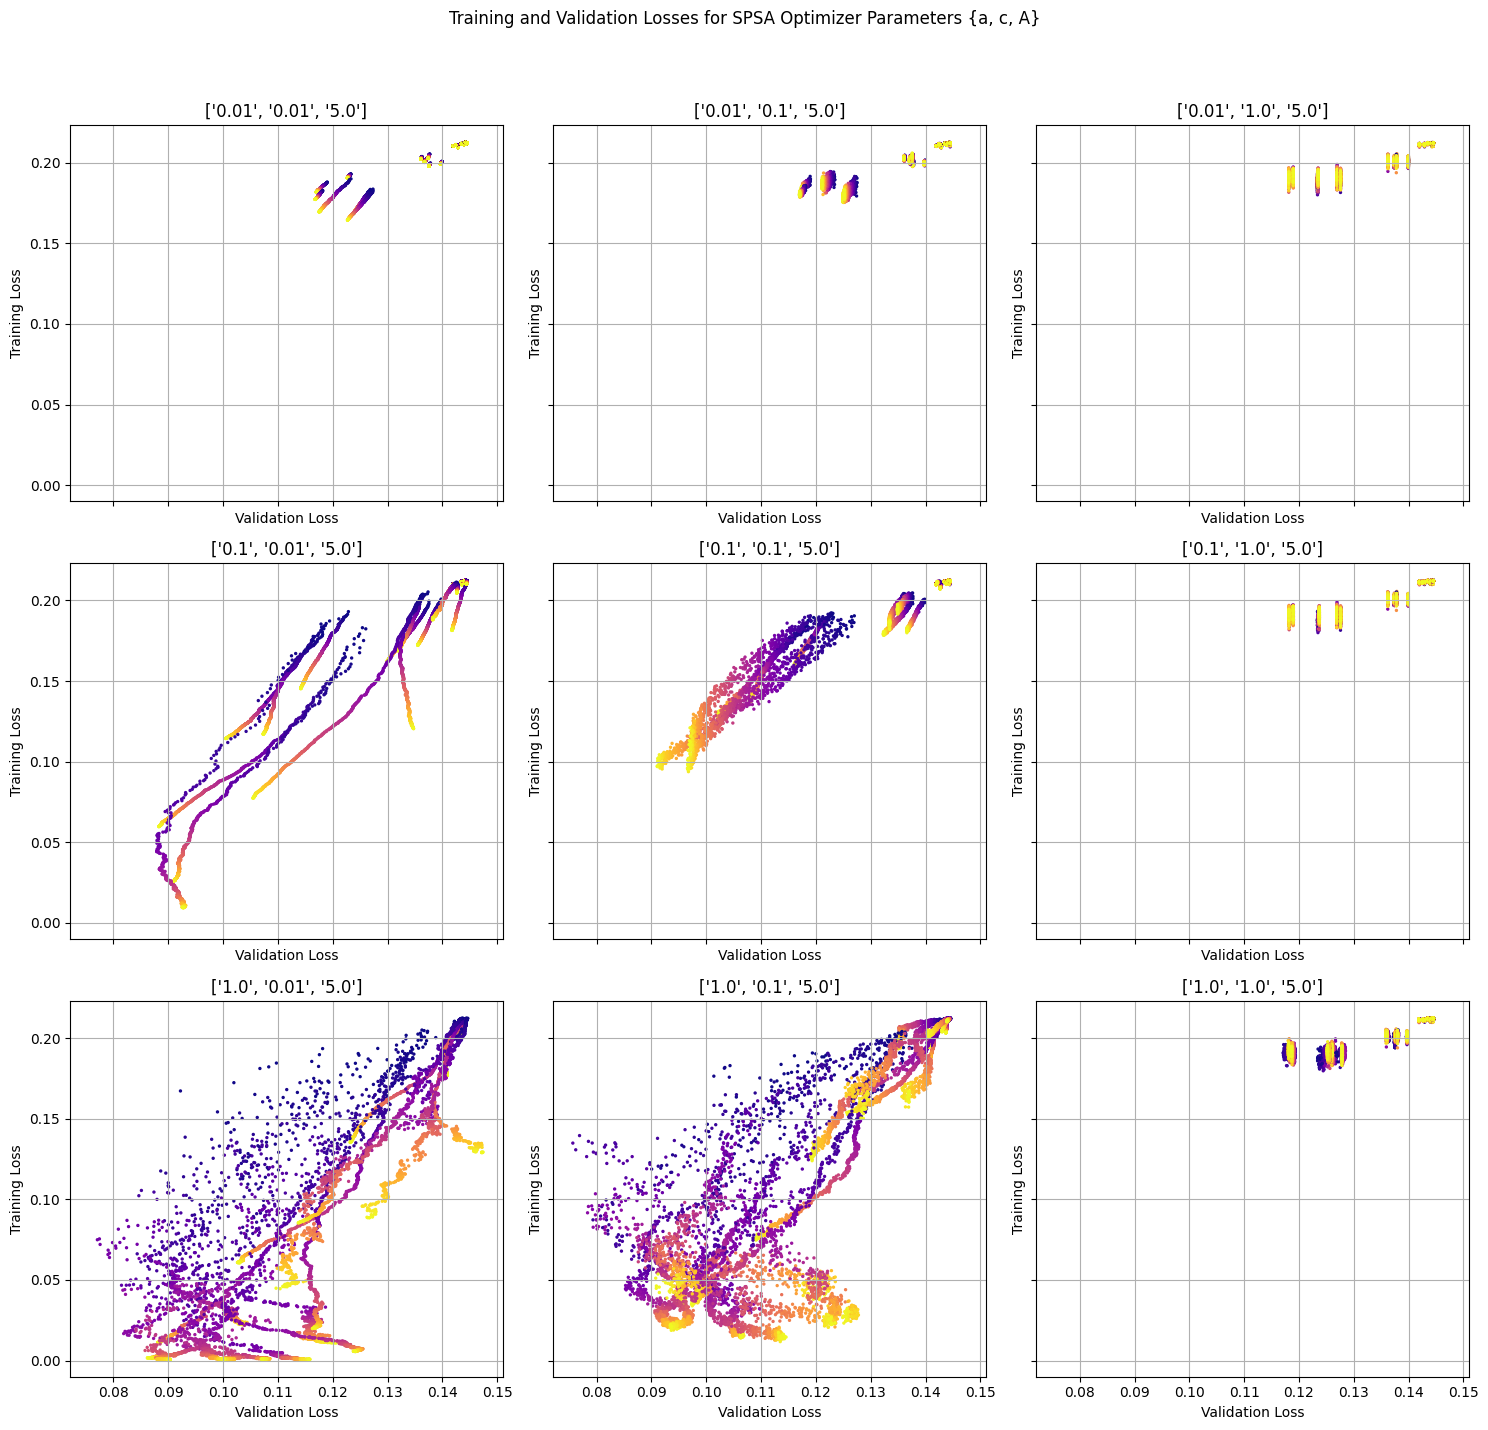

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_models_info contains the list of dictionaries with model information
# Filter the models where optimizer_hyperparams_str[0] == '0.01'
filtered_models = [model_info for model_info in all_models_info]# if model_info['optimizer_hyperparams_str'][0] == '0.01']

# Get unique optimizer parameter configurations and their respective counts
optimizer_params_values, counts = np.unique([tuple(model_info['optimizer_hyperparams_str']) for model_info in filtered_models], axis=0, return_counts=True)

# Filter unique configurations that have at least two occurrences (repeats)
unique_configs_with_repeats = optimizer_params_values[counts >= 2]

# Determine the number of unique configurations
num_subplots = len(unique_configs_with_repeats)

# Make sure there are at most 9 unique configurations
unique_configs_with_repeats = unique_configs_with_repeats[:9]

# Set up the subplots in a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

# Flatten the axs array for easier plotting
axs = axs.ravel()

# Define the parameter combinations to be plotted in the grid
parameter_combinations = [
    ['0.01', '0.01', '5.0'], ['0.01', '0.1', '5.0'], ['0.01', '1.0', '5.0'],
    ['0.1', '0.01', '5.0'], ['0.1', '0.1', '5.0'], ['0.1', '1.0', '5.0'],
    ['1.0', '0.01', '5.0'], ['1.0', '0.1', '5.0'], ['1.0', '1.0', '5.0']
]

for i, params_value in enumerate(parameter_combinations):
    ax = axs[i]
    filtered_models_for_params = [model_info for model_info in filtered_models if model_info['optimizer_hyperparams_str'] == list(params_value)]
    
    for model_info in filtered_models_for_params:
        num_epochs = model_info['num_epochs']
        training_losses = model_info['training_losses']
        validation_losses = model_info['validation_losses']

        epochs = range(1, num_epochs + 1)

        ax.scatter(validation_losses, training_losses, c=epochs, cmap='plasma', label=f"Seed={model_info['seed']}", s=2)
        ax.set_xlabel('Validation Loss')
        ax.set_ylabel('Training Loss')
        ax.set_title(f"{params_value}")
        ax.grid(True)

        if len(ax.collections) > 0:
            pass
plt.suptitle('Training and Validation Losses for SPSA Optimizer Parameters {a, c, A}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Ansatz

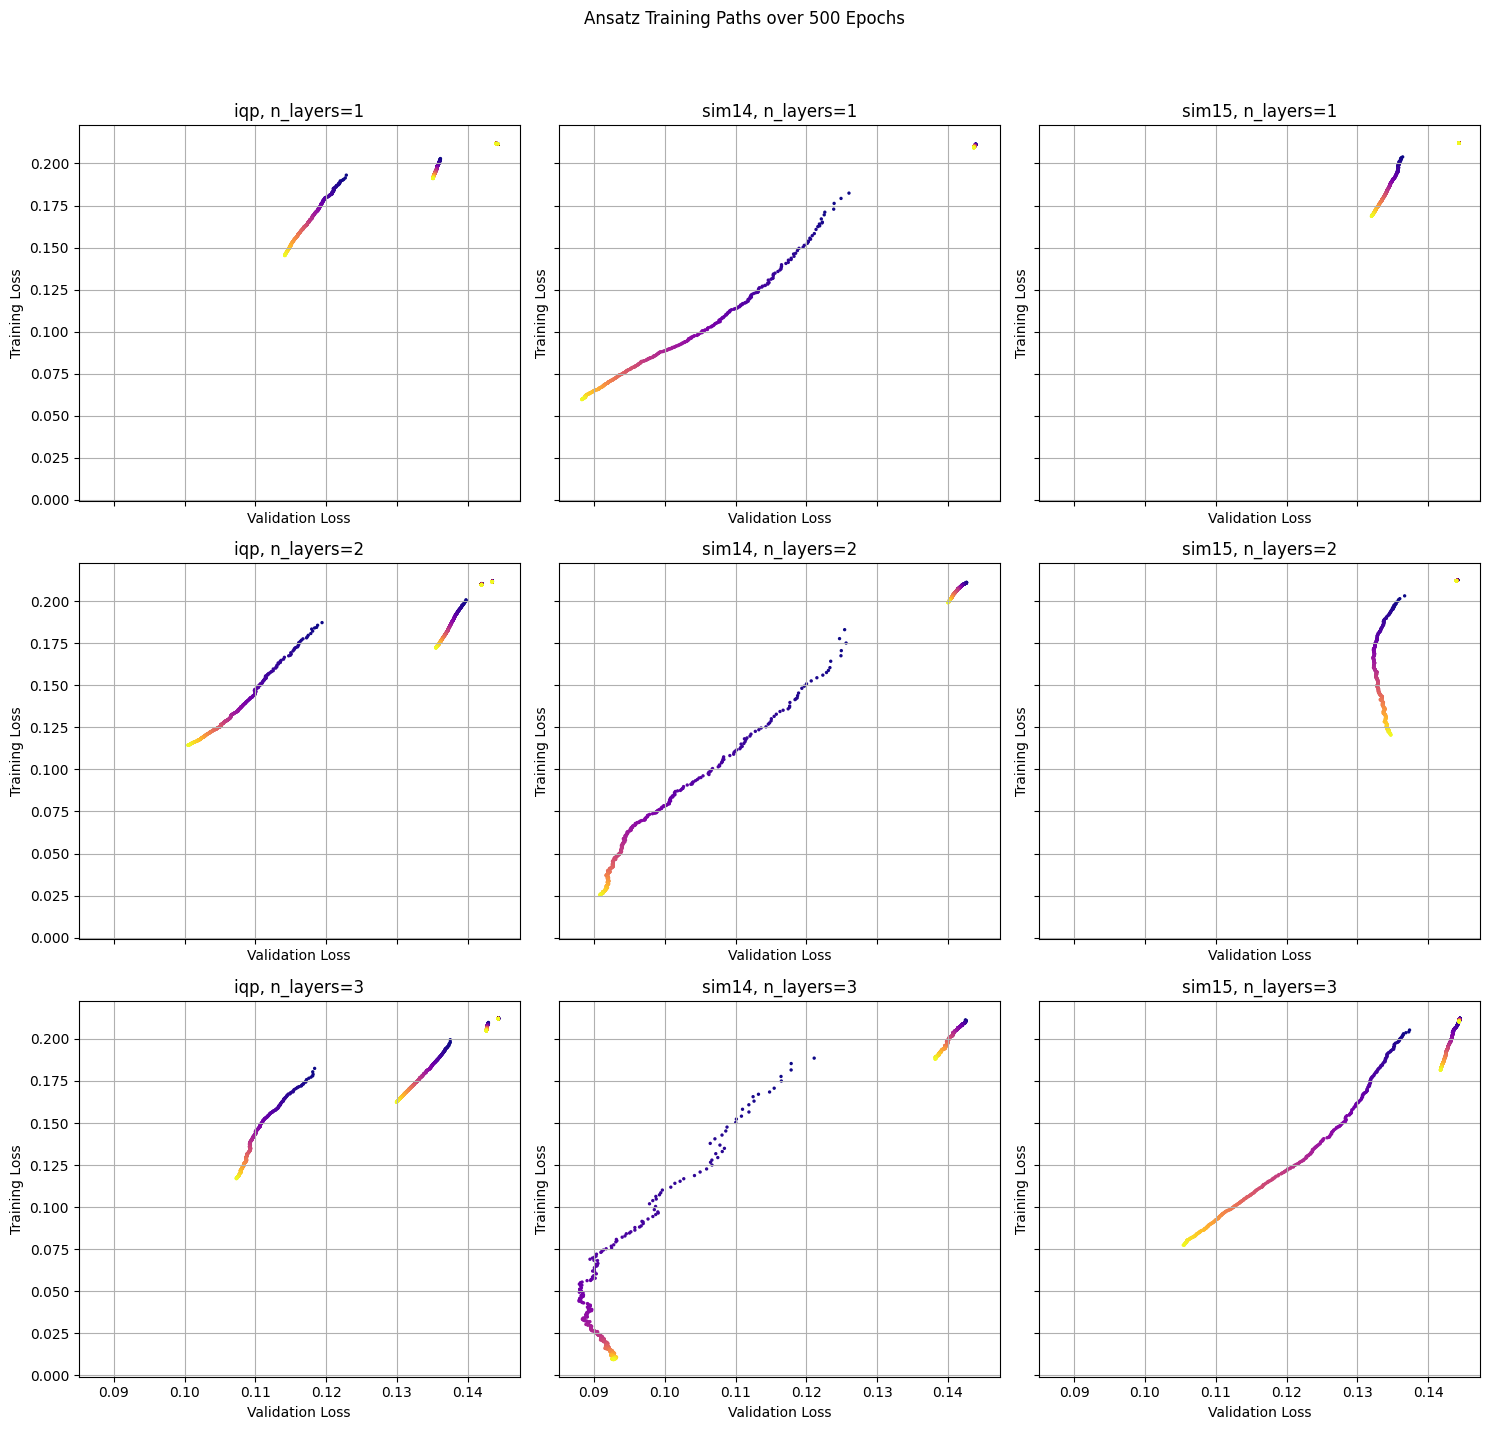

In [30]:
import numpy as np
import matplotlib.pyplot as plt

useful_models = [model for model in all_models_info if model['optimizer_hyperparams_str'] == ['0.1', '0.01', '5.0']]
ansatz_names = ['iqp', 'sim14', 'sim15']
n_layers_values = [1, 2, 3]

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

for row, n_layers in enumerate(n_layers_values):
    for col, ansatz_name in enumerate(ansatz_names):
        ax = axes[row, col]
        
        # Swap these below two lines for plotting chosen settings or all settings 
        ansatz_n_layers_models = [model for model in useful_models if model['ansatz_name'] == ansatz_name and int(model['ansatz_hyperparams_str'][-1]) == n_layers]
        # ansatz_n_layers_models = [model for model in all_models_info if model['ansatz_name'] == ansatz_name and int(model['ansatz_hyperparams_str'][-1]) == n_layers]

        for model in ansatz_n_layers_models:
            num_epochs = model['num_epochs']
            training_losses = model['training_losses']
            validation_losses = model['validation_losses']

            epochs = range(1, num_epochs + 1)

            ax.scatter(validation_losses, training_losses, c=epochs, cmap='plasma', label=f"Seed={model['seed']}", s=2)
            ax.set_title(f"{ansatz_name}, n_layers={n_layers}")
            ax.set_xlabel("Validation Loss")
            ax.set_ylabel("Training Loss")
            ax.grid(True)
plt.suptitle('Ansatz Training Paths over 500 Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Dimension Reduction

### Plot Settings

C:\Users\henry\AppData\Local\Temp\ipykernel_47220\3321814669.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)


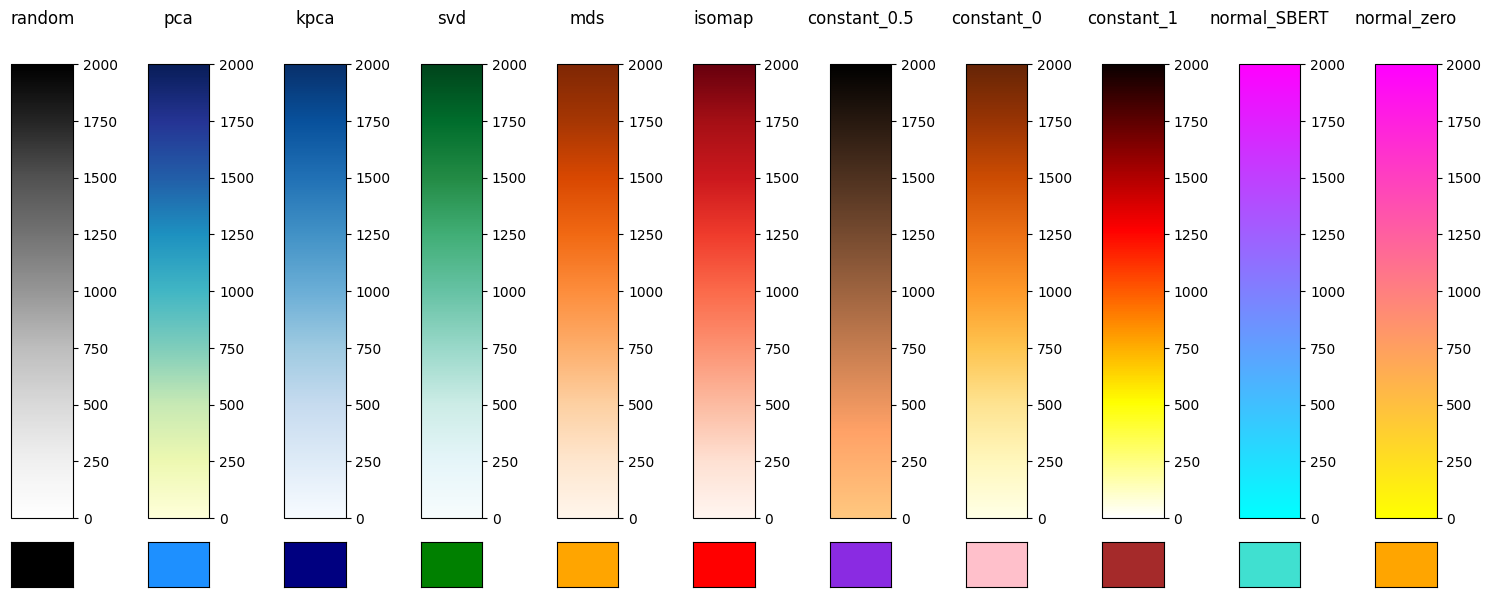

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib as mpl

fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, len(color_map), height_ratios=[1, 0.1])

for i, (label, cmap_name) in enumerate(color_map.items()):
    ax_colorbar = plt.subplot(gs[0, i])
    ax_color = plt.subplot(gs[1, i])
    
    cmap = mpl.cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=0, vmax=2000)
    
    cb = mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap, norm=norm, orientation='vertical')
    ax_colorbar.text(0.5, 1.1, label, va='center', ha='center', transform=ax_colorbar.transAxes, fontsize=12, color='black')
    
    rect = patches.Rectangle((0, 0), 1, 1, color=line_color_map[label])
    ax_color.add_patch(rect)
    
    ax_color.set_xlim(0, 1)
    ax_color.set_ylim(0, 1)
    ax_color.set_xticks([])
    ax_color.set_yticks([])

plt.tight_layout()
plt.show()

## Single Settings Graph

(0.097, 0.2135)

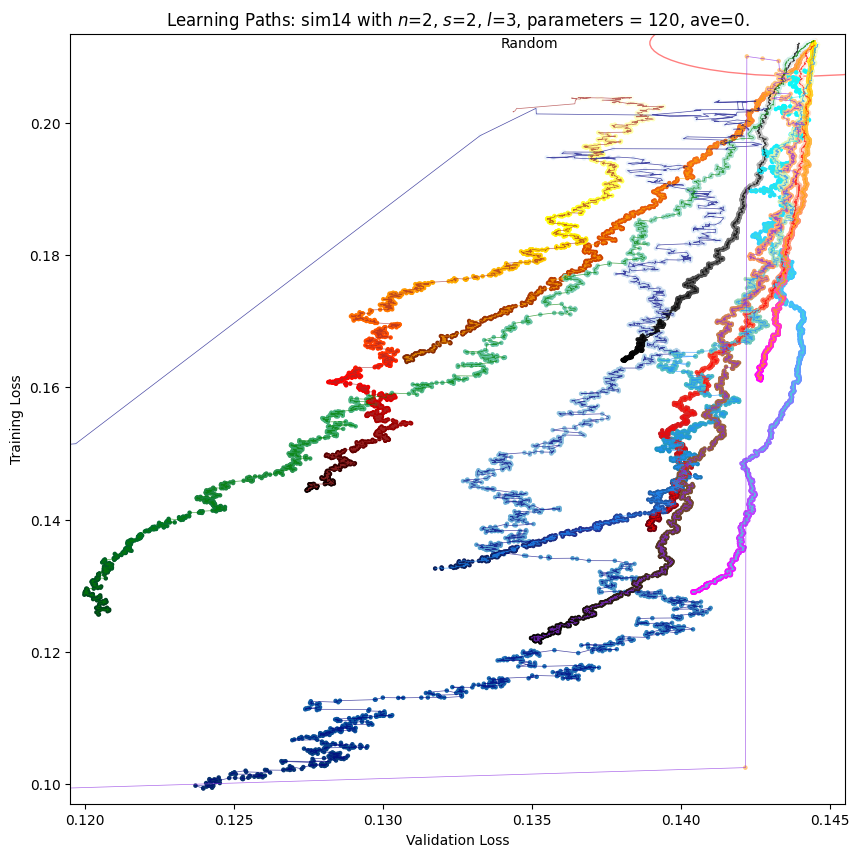

In [25]:
n = '2'
s = '2'
layers = '3'
ansatz = 'sim14'

parameters_to_extract = {
    "ansatz_name": ansatz,
    'ansatz_hyperparams_str': [(n, s, layers)],
}

extracted_models = extract_models_with_parameters(parameters_to_extract, all_reduced_models)

average_window = 0

fig = plt.figure(figsize=(10, 10))
added_labels = set()

for i, model_info in enumerate(extracted_models):
    if "uniform" in model_info['model_type']:
        names = model_info['model_type'].split("-")
        model_type = "constant_" +  names[1]
    elif "normal" in model_info['model_type']:
        model_type = "normal_" +  model_info['embedding_type']
    else:
        model_type = model_info['model_type']
    
    num_epochs = model_info['num_epochs']
    training_losses = model_info['training_losses']
    validation_losses = model_info['validation_losses']

    epochs = np.arange(1, num_epochs + 1)

    cmap = color_map.get(model_type)
    if cmap is None:
        continue

    if model_type in added_labels:
        iterations_label = None
    else:
        iterations_label = model_type
        added_labels.add(model_type)
    
    if average_window > 0:
        training_losses = moving_average(training_losses, average_window)
        validation_losses = moving_average(validation_losses, average_window)
        epochs = epochs[average_window - 1:]
        
    plt.scatter(
        validation_losses,
        training_losses,
        c=epochs,
        cmap=cmap,
        s=5
    )
    line_color = line_color_map[model_type]
    plt.plot(
        validation_losses,
        training_losses,
        color=line_color,
        linewidth=0.5,
        alpha=0.7,
        label=iterations_label
    )
    
    if iterations_label == 'random':
        x = validation_losses[0]
        y = training_losses[0]
        a = 0.01  
        circle = plt.Circle((x, y), a/2, fill=False, color='r', alpha=0.5)
        plt.gca().add_artist(circle)

        label = "Random"
        text_x = x - a  
        text_y = y
        plt.text(text_x, text_y, label, color='k', fontsize=10, va='center')


"""leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(3.0)"""

param = calc_param_from_ansatz(ansatz, n, s, layers)
plt.xlabel('Validation Loss')
plt.ylabel('Training Loss')
plt.title(f'Learning Paths: {ansatz} with $n$={n}, $s$={s}, $l$={layers}, parameters = {param}, ave={average_window}.')

# IQP 1 1 1 
#plt.xlim(0.043, 0.133)
#plt.ylim(0.01, 0.203)

# IQP 2 2 3
#plt.xlim(0.065, 0.145)
#plt.ylim(0.0, 0.22)

# sim15 1 1 1
#plt.xlim(0.043, 0.14)
#plt.ylim(0.00, 0.203)

# sim15 2 2 3
#plt.xlim(0.12, 0.145)
#plt.ylim(0.11, 0.22)

# sim14 2 2 3
plt.xlim(0.1195, 0.1455)
plt.ylim(0.097, 0.2135)

# sim14 1 1 1
#plt.xlim(0.08, 0.135)
#plt.ylim(0.00, 0.205)

## All Settings for 1 Ansatz

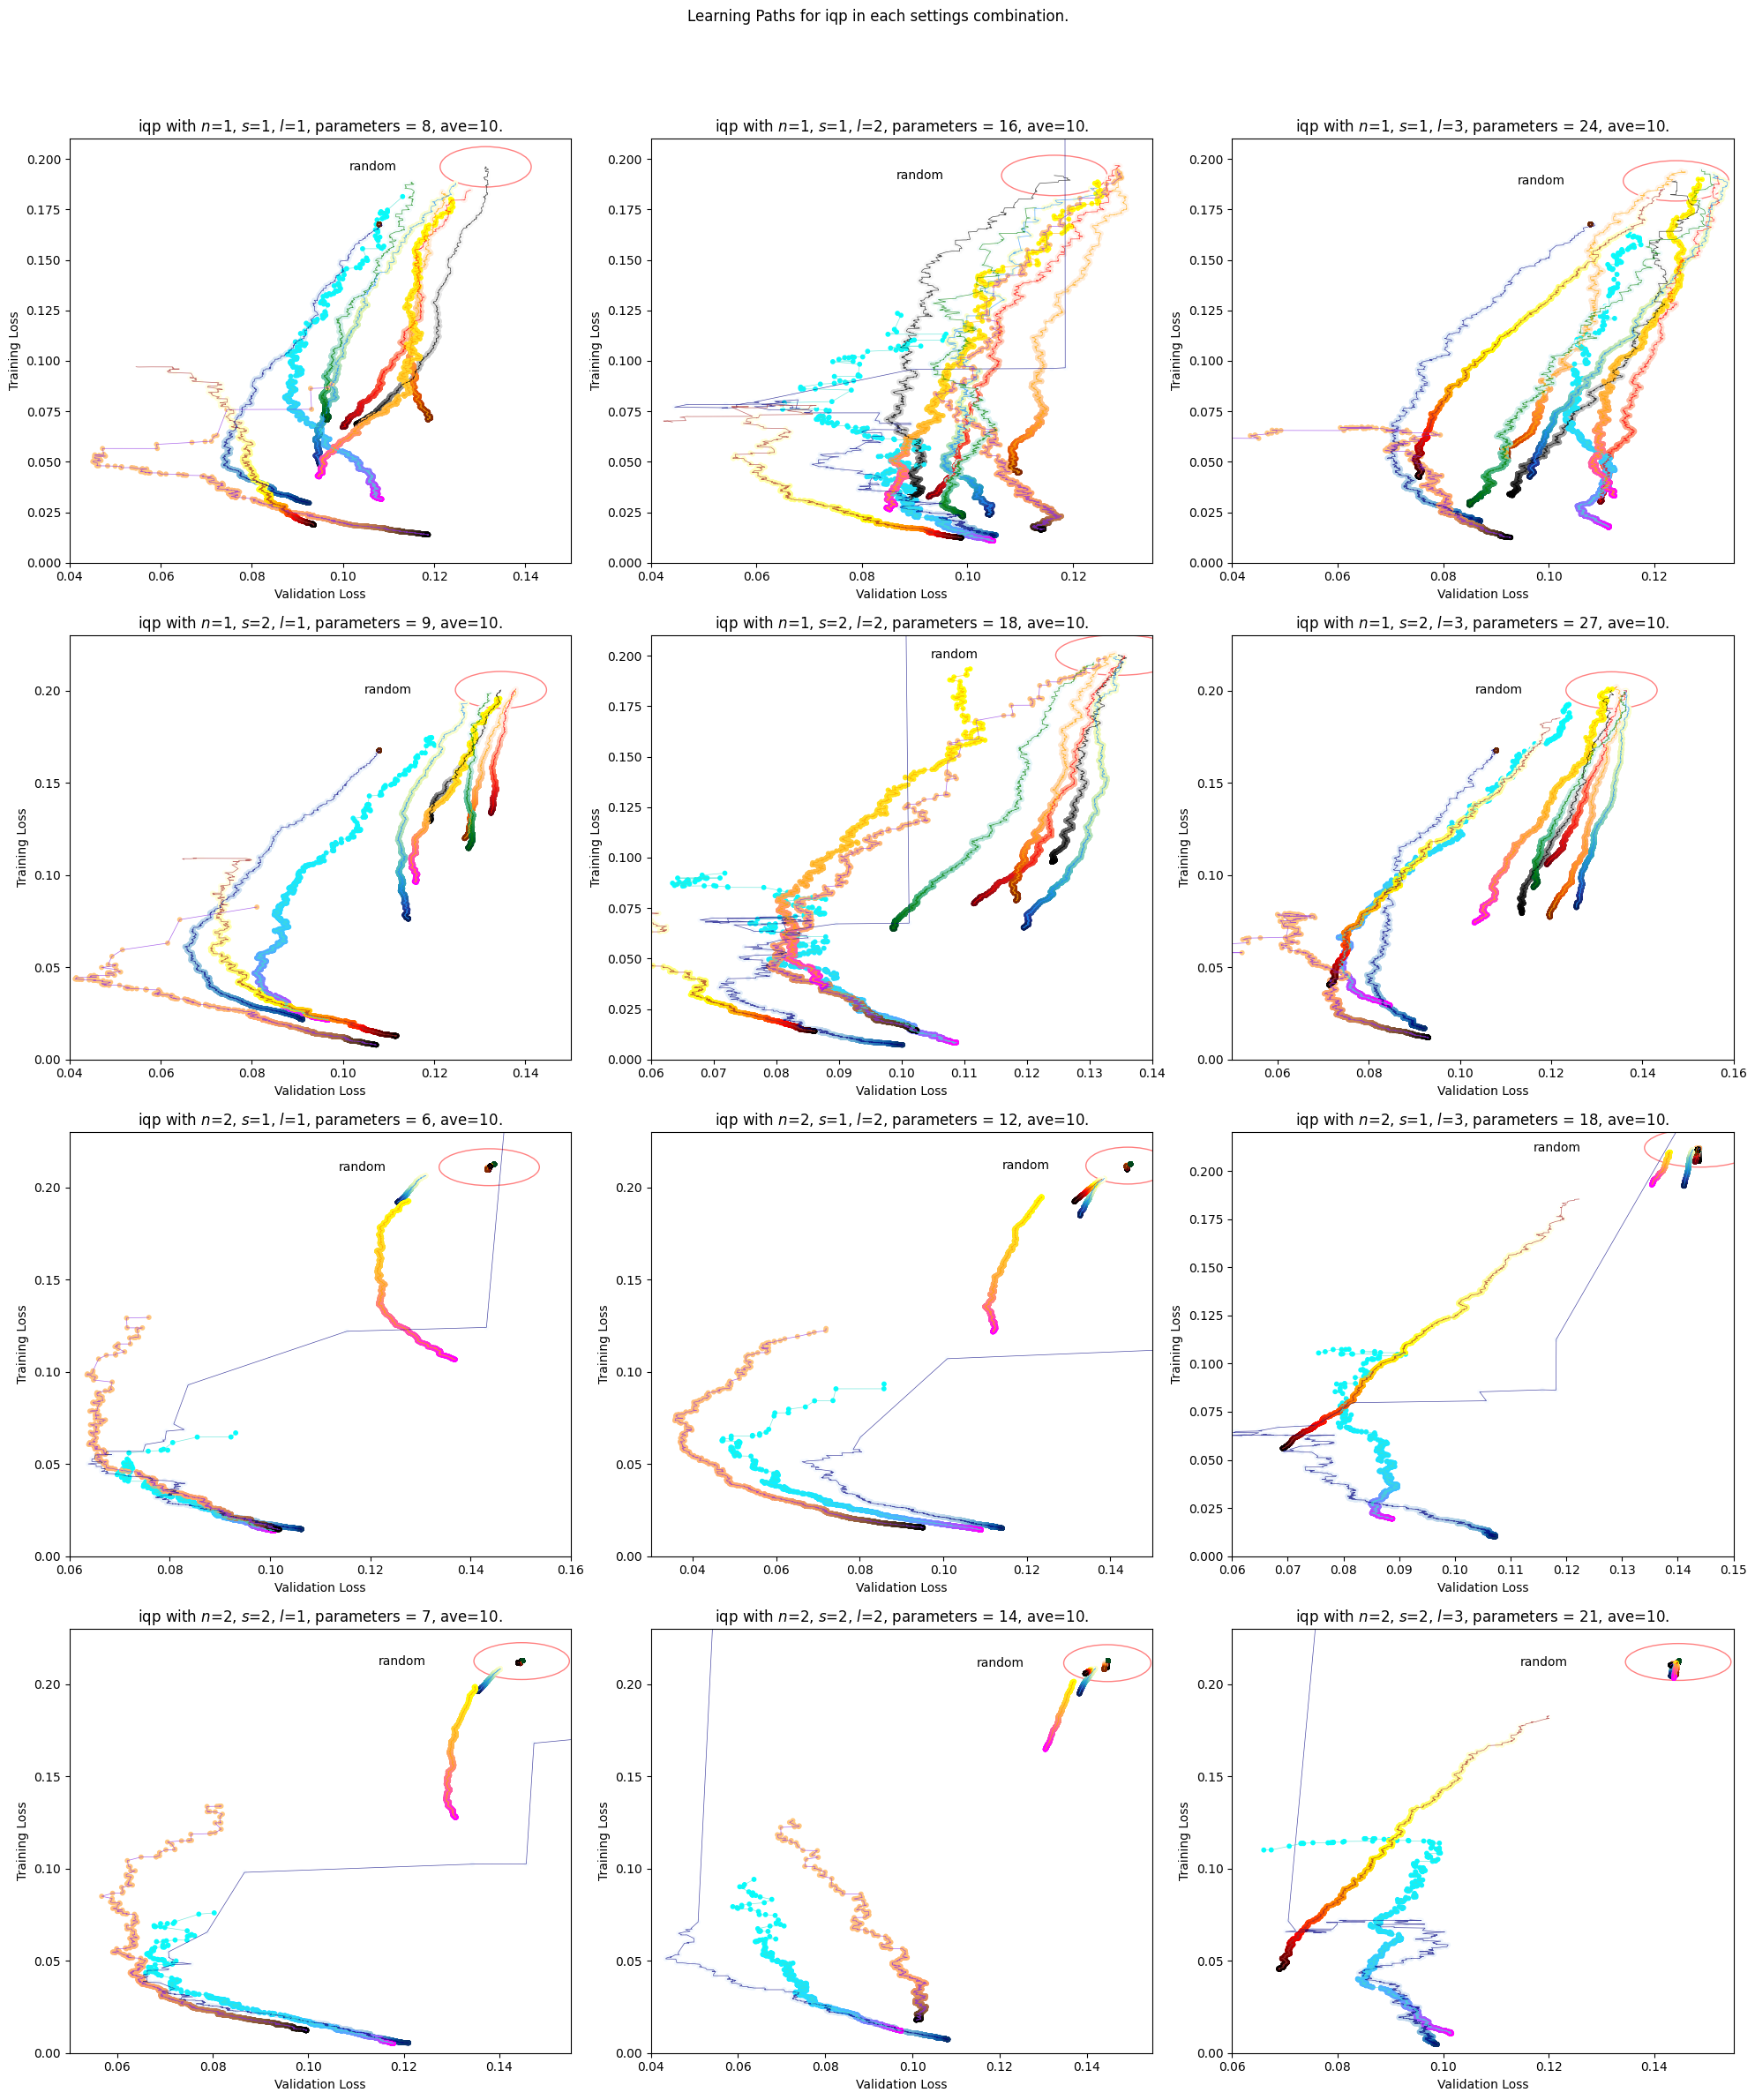

In [4]:
ansatz = 'iqp'
graph_scale_params = custom_params[ansatz]
fig, axs = plt.subplots(len(n_values) * len(s_values), len(layers_values), figsize=(20, 25), sharex=False, sharey=False)

lines = []
for i, n in enumerate(n_values):
    for j, s in enumerate(s_values):
        for k, layers in enumerate(layers_values):
            parameters_to_extract = {
                "ansatz_name": ansatz,
                'ansatz_hyperparams_str': [(n, s, layers)],
            }

            filtered_models = extract_models_with_parameters(parameters_to_extract, all_reduced_models)

            ax = axs[i * len(s_values) + j, k]
            
            custom_values = graph_scale_params.get((n, s, layers), {})
            xlim = custom_values.get('xlim', (0.0, 1.0))
            ylim = custom_values.get('ylim', (0.0, 1.0))
            average_window = custom_values.get('average_window', 5)
            circle_radius = custom_values.get('circle_radius', 0.01)

            added_labels = []
            
            for m, model_info in enumerate(filtered_models):  
                if "uniform" in model_info['model_type']:
                    names = model_info['model_type'].split("-")
                    model_type = "constant_" +  names[1]
                elif "normal" in model_info['model_type']:
                    model_type = "normal_" +  model_info['embedding_type']
                else:
                    model_type = model_info['model_type']
                
                num_epochs = model_info['num_epochs']
                training_losses = model_info['training_losses']
                validation_losses = model_info['validation_losses']

                epochs = np.arange(1, num_epochs + 1)
                
                cmap = color_map.get(model_type)
                if cmap is None:
                    continue
                line_color = line_color_map.get(model_type, 'gray')
                iterations_label = model_type if model_type not in added_labels else None

                ax.scatter(
                    validation_losses,
                    training_losses,
                    c=epochs,
                    cmap=cmap,
                    s=10
                )
                ax.plot(
                    validation_losses,
                    training_losses,
                    color=line_color,
                    linewidth=0.5,
                    alpha=0.7,
                    label=model_type
                )
                
                # Circling Random Initialisation
                if model_info['model_type'] =='random':
                    x = validation_losses[0]
                    y = training_losses[0]
                    circle = Circle((x, y), abs(circle_radius), fill=False, color='r', alpha=0.5)
                    ax.add_artist(circle)

                    label = "random"
                    text_x = x + 3*circle_radius
                    text_y = y
                    ax.text(text_x, text_y, label, color='k', fontsize=10, va='center')
            param = calc_param_from_ansatz(ansatz, n, s, layers)
            ax.set_title(f'{ansatz} with $n$={n}, $s$={s}, $l$={layers}, parameters = {param}, ave={average_window}.')
            ax.set_xlabel('Validation Loss')
            ax.set_ylabel('Training Loss')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

plt.suptitle(f'Learning Paths for {ansatz} in each settings combination.')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("AAA")

# Random Models

### Single Settings with Paths

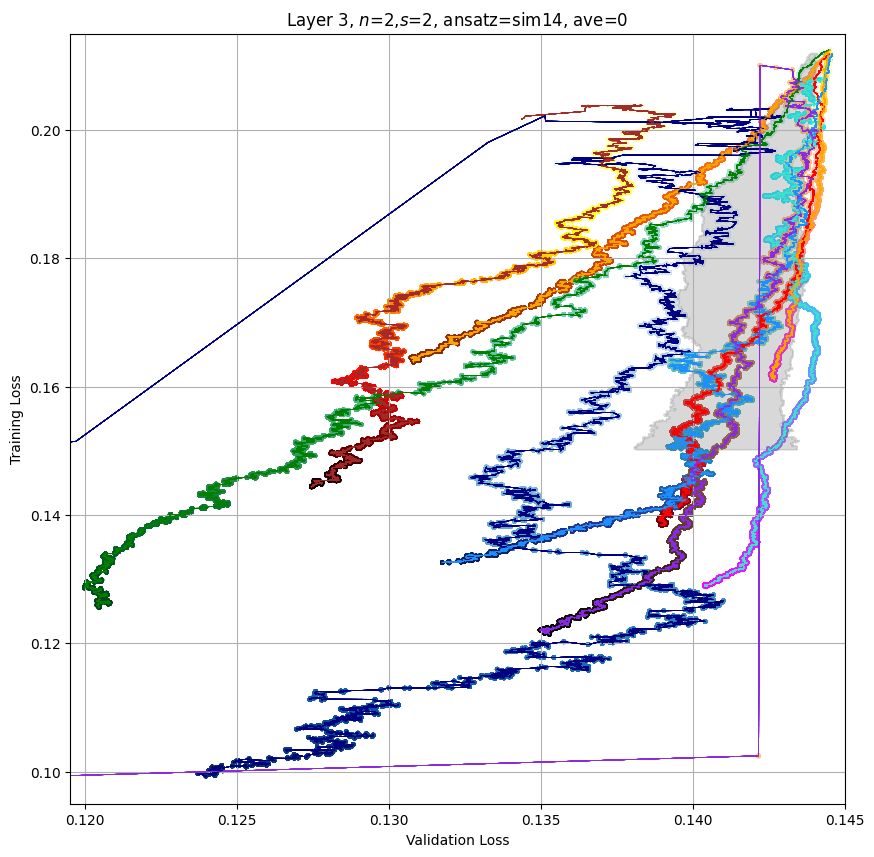

In [26]:
n = '2'
s = '2'
layers = '3'
ansatz = 'sim14'

parameters_to_extract = {
    "ansatz_name": ansatz,
    'ansatz_hyperparams_str': [(n, s, layers)],
}
graph_scale_params = custom_params[ansatz]

filtered_models = extract_models_with_parameters(parameters_to_extract, all_random_models) + extract_models_with_parameters(parameters_to_extract, all_reduced_models) # Your list of filtered models

average_window = 0
fig = plt.figure(figsize=(10, 10))
added_labels = set()
ax = fig.add_subplot(111)  # Initialize the ax variable
for i, model_info in enumerate(filtered_models):
    # Example usage:
    parameters_to_extract = {
        "ansatz_name": ansatz,
        'ansatz_hyperparams_str': [(n, s, layers)],
    }
    filtered_models = extract_models_with_parameters(parameters_to_extract, all_random_models) + extract_models_with_parameters(parameters_to_extract, all_reduced_models) # Your list of filtered models

    added_labels = set()
    random_train = np.zeros(shape=(len(filtered_models), 20006))
    random_val = np.zeros(shape=(len(filtered_models), 20006))
    for l, model_info in enumerate(filtered_models):
        if "uniform" in model_info['model_type']:
            names = model_info['model_type'].split("-")
            model_type = "constant_" +  names[1]
        elif "normal" in model_info['model_type']:
            model_type = "normal_" +  model_info['embedding_type']
        else:
            model_type = model_info['model_type']
        num_epochs = model_info['num_epochs']
        training_losses = model_info['training_losses']
        validation_losses = model_info['validation_losses']
        custom_values = graph_scale_params.get((n, s, layers), {})
        xlim = custom_values.get('xlim', (0.0, 1.0))
        ylim = custom_values.get('ylim', (0.0, 1.0))
        average_window = custom_values.get('average_window', (0.0, 1.0))
        epochs = np.arange(1, num_epochs + 1)

        cmap = color_map.get(model_type)
        if cmap is None:
            continue

        if model_type in added_labels:
            iterations_label = None
        else:
            iterations_label = model_type
            added_labels.add(model_type)

        line_color = line_color_map.get(model_type, '')

        if model_type == 'random':
            random_train[l, :len(training_losses)] = training_losses
            random_val[l, :len(validation_losses)] = validation_losses

        if average_window > 0:
            training_losses = moving_average(training_losses, average_window)
            validation_losses = moving_average(validation_losses, average_window)
            epochs = epochs[average_window - 1:]

        
        
        if model_type != 'random':
            ax.scatter(
                validation_losses,
                training_losses,
                c=epochs,
                cmap=cmap,
                label=iterations_label,
                s=5
            )
            plt.plot(
                validation_losses,
                training_losses,
                color=line_color,
                linewidth=0.5,
                alpha=0.7,
                label=iterations_label
            )

max_train = np.ma.masked_where(random_train == 0, random_train).max(axis=0)
min_train = np.ma.masked_where(random_train == 0, random_train).min(axis=0)
max_val = np.ma.masked_where(random_val == 0, random_val).max(axis=0)
min_val = np.ma.masked_where(random_val == 0, random_val).min(axis=0)

ax.fill_betweenx(
    min_train,
    min_val,
    max_val,
    color='Grey',
    alpha=0.3,
    label='Random Models Area'
)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

param = calc_param_from_ansatz(ansatz, n, s, layers)
ax.set_title(f'{ansatz} with $n$={n}, $s$={s}, $l$={layers}, parameters = {param}, ave={average_window}.')
ax.grid(True)

plt.xlabel('Validation Loss')
plt.ylabel('Training Loss')
plt.title(f'Layer {layers}, $n$={n},$s$={s}, ansatz={ansatz}, ave={average_window}')
plt.grid(True)

plt.show()

## All Settings Shaded

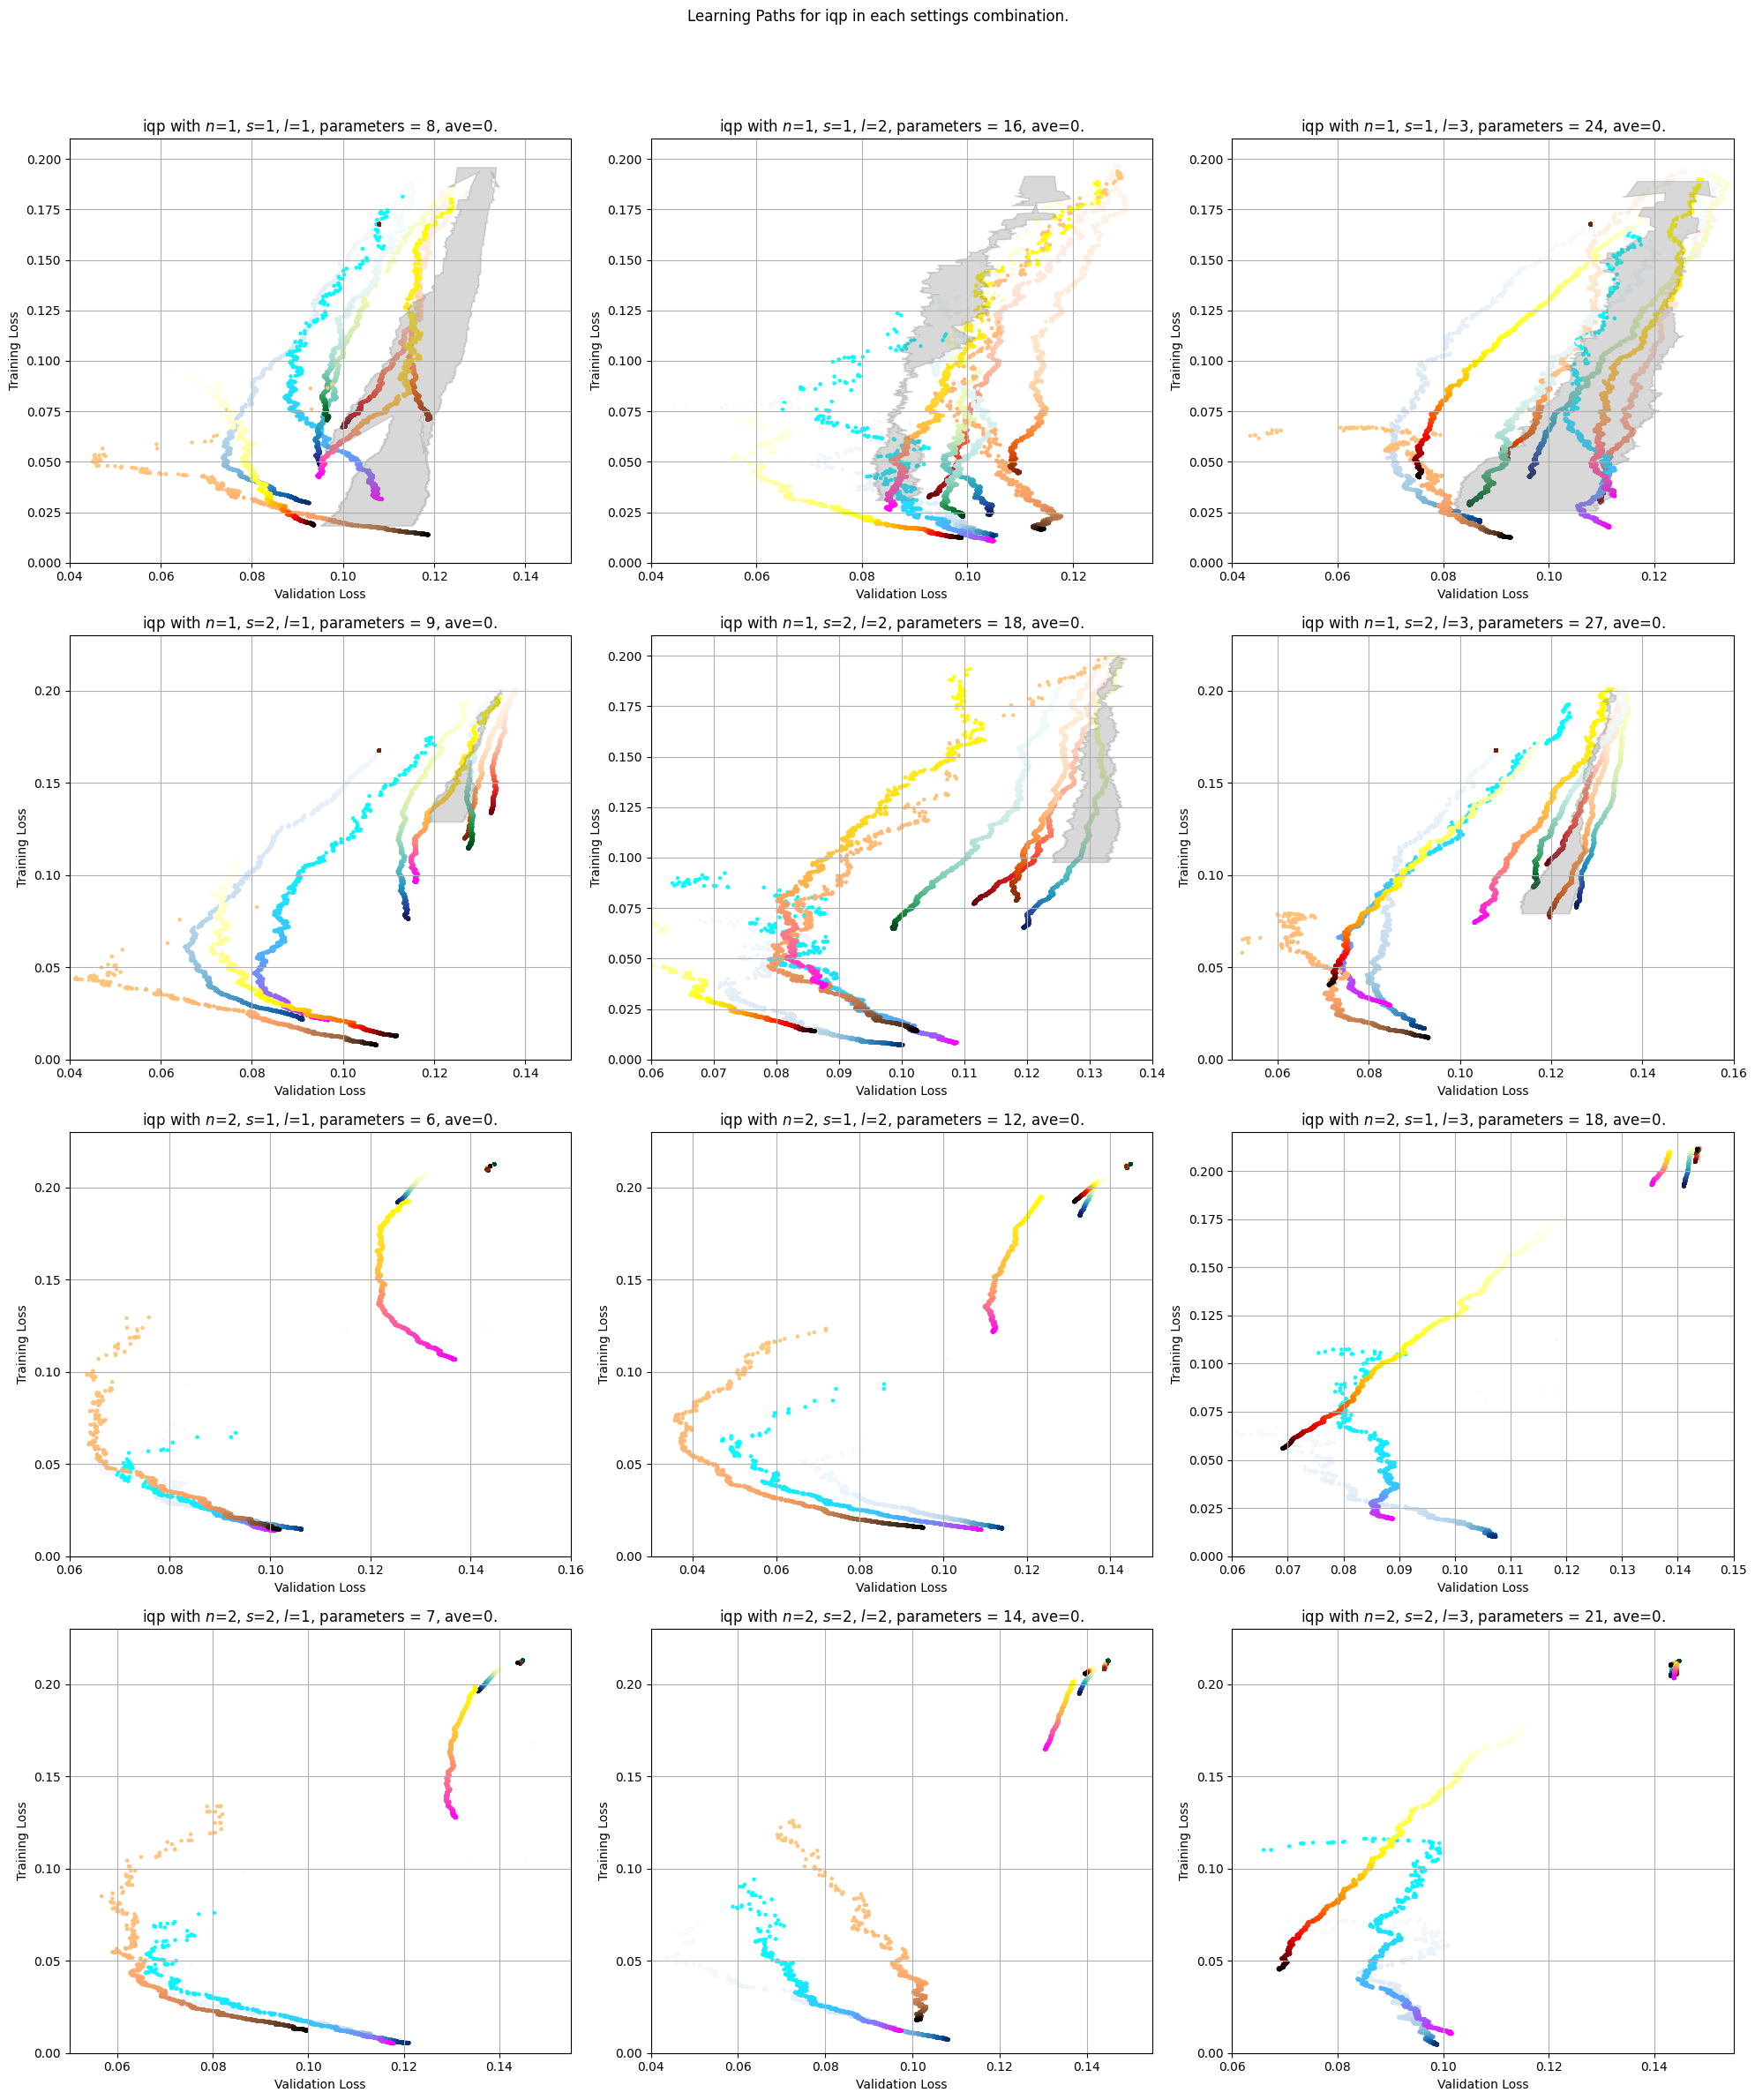

In [19]:
ansatz = 'iqp'

graph_scale_params = custom_params[ansatz]

s_values = ['1', '2']
n_values = ['1', '2']
layers_values = ['1', '2', '3']

average_window = 10 
fig, axs = plt.subplots(len(n_values) * len(s_values), len(layers_values), figsize=(20, 25), sharex=False, sharey=False)

for i, n in enumerate(n_values):
    for j, s in enumerate(s_values):
        for k, layers in enumerate(layers_values):
            ax = axs[i * len(s_values) + j, k]
            # Example usage:
            parameters_to_extract = {
                "ansatz_name": ansatz,
                'ansatz_hyperparams_str': [(n, s, layers)],
            }
            filtered_models = extract_models_with_parameters(parameters_to_extract, all_random_models) + extract_models_with_parameters(parameters_to_extract, all_reduced_models) # Your list of filtered models

            added_labels = set()
            random_train = np.zeros(shape=(len(filtered_models), 20006))
            random_val = np.zeros(shape=(len(filtered_models), 20006))
            for l, model_info in enumerate(filtered_models):
                if "uniform" in model_info['model_type']:
                    names = model_info['model_type'].split("-")
                    model_type = "constant_" +  names[1]
                elif "normal" in model_info['model_type']:
                    model_type = "normal_" +  model_info['embedding_type']
                else:
                    model_type = model_info['model_type']
                num_epochs = model_info['num_epochs']
                training_losses = model_info['training_losses']
                validation_losses = model_info['validation_losses']
                custom_values = graph_scale_params.get((n, s, layers), {})
                xlim = custom_values.get('xlim', (0.0, 1.0))
                ylim = custom_values.get('ylim', (0.0, 1.0))
                average_window = custom_values.get('average_window', (0.0, 1.0))
                epochs = np.arange(1, num_epochs + 1)

                cmap = color_map.get(model_type)
                if cmap is None:
                    continue

                if model_type in added_labels:
                    iterations_label = None
                else:
                    iterations_label = model_type
                    added_labels.add(model_type)

                line_color = line_color_map.get(model_type, '')

                if model_type == 'random':
                    random_train[l, :len(training_losses)] = training_losses
                    random_val[l, :len(validation_losses)] = validation_losses

                if average_window > 0:
                    training_losses = moving_average(training_losses, average_window)
                    validation_losses = moving_average(validation_losses, average_window)
                    epochs = epochs[average_window - 1:]

                if model_type != 'random':
                    ax.scatter(
                        validation_losses,
                        training_losses,
                        c=epochs,
                        cmap=cmap,
                        label=iterations_label,
                        s=5
                    )
            max_train = np.ma.masked_where(random_train == 0, random_train).max(axis=0)
            min_train = np.ma.masked_where(random_train == 0, random_train).min(axis=0)
            max_val = np.ma.masked_where(random_val == 0, random_val).max(axis=0)
            min_val = np.ma.masked_where(random_val == 0, random_val).min(axis=0)

            ax.fill_betweenx(
                min_train,
                min_val,
                max_val,
                color='grey',
                alpha=0.3,
                label='Random Models Area'
            )

            ax.set_xlabel('Validation Loss')
            ax.set_ylabel('Training Loss')
            param = calc_param_from_ansatz(ansatz, n, s, layers)
            ax.set_title(f'{ansatz} with $n$={n}, $s$={s}, $l$={layers}, parameters = {param}, ave={average_window}.')
            ax.grid(True)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

plt.suptitle(f'Learning Paths for {ansatz} in each settings combination.')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Convergences

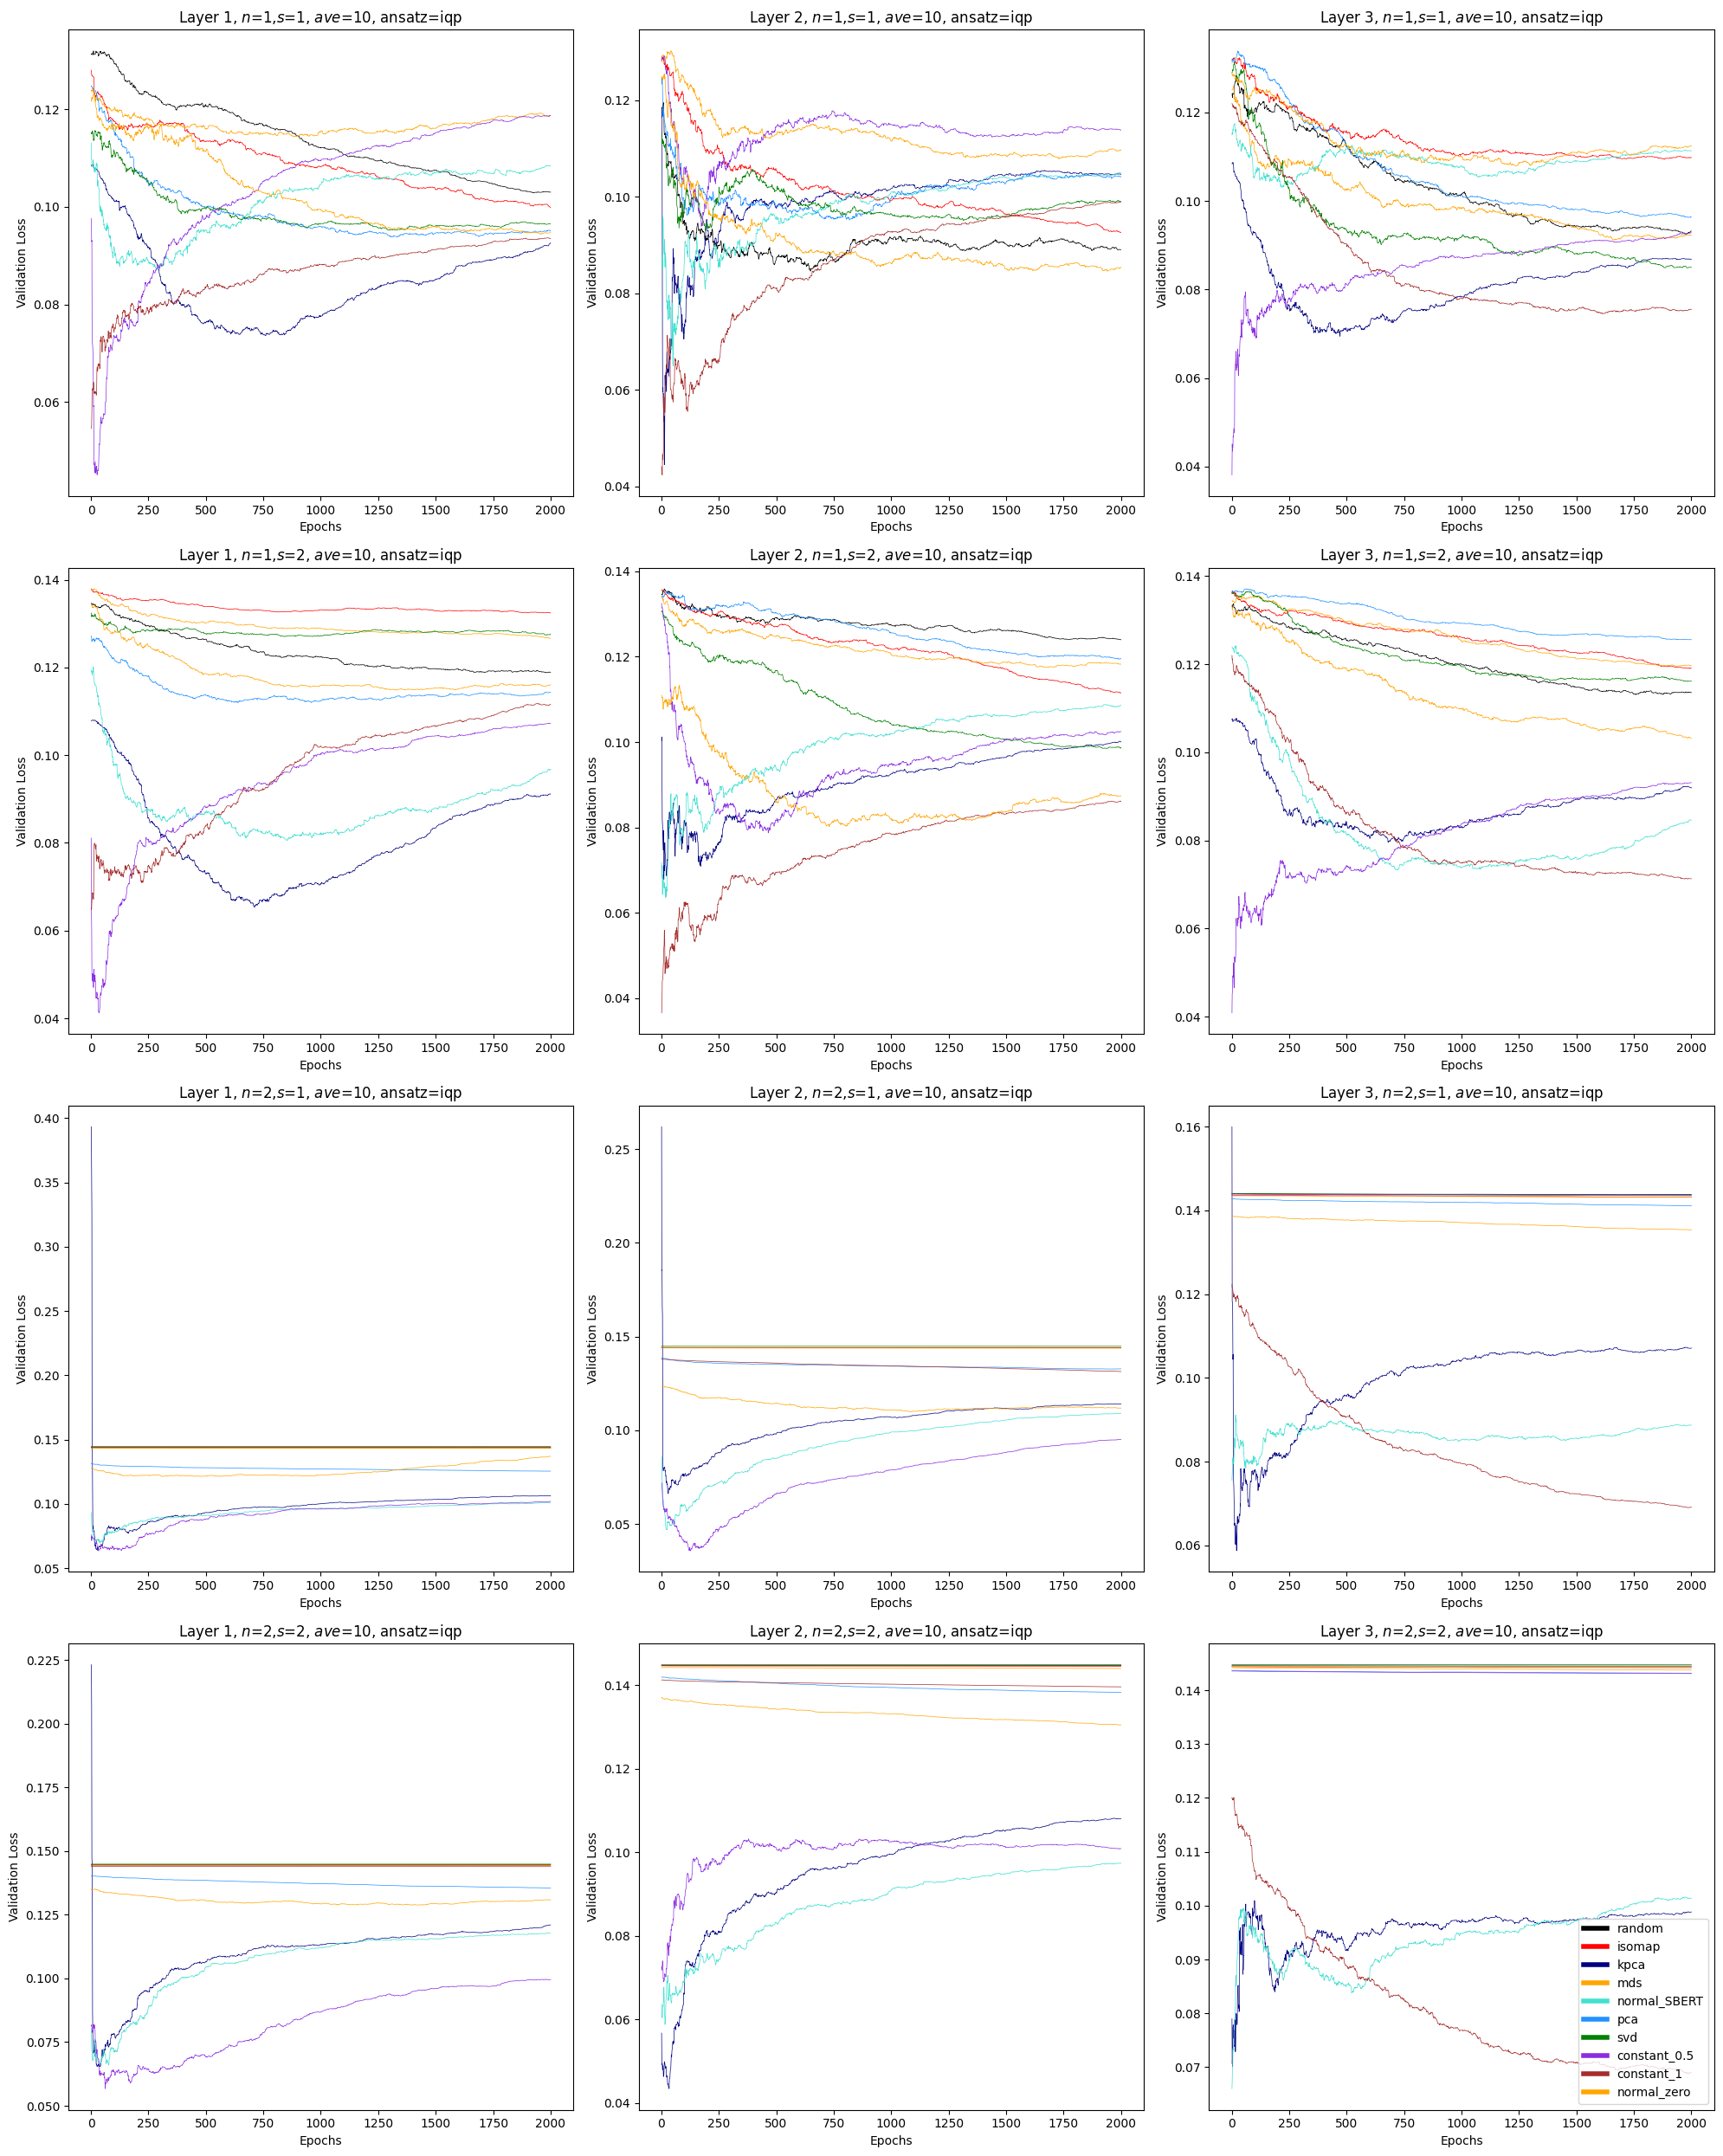

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Define the parameter values
ansatz = 'iqp'
s_values = ['1', '2']
n_values = ['1', '2']
layers_values = ['1', '2', '3']

# Create a dictionary to store custom values for each subplot

# Create subplots
fig, axs = plt.subplots(len(n_values) * len(s_values), len(layers_values), figsize=(20, 25), sharex=False, sharey=False)

filtering_parameters = {
    'model_type':[i['model_type'] for i in all_reduced_models if i['model_type'] != 'uniform-0']
}

models_to_use = extract_models_with_parameters(filtering_parameters, all_reduced_models)

for i, n in enumerate(n_values):
    for j, s in enumerate(s_values):
        for k, layers in enumerate(layers_values):
            parameters_to_extract = {
                "ansatz_name": ansatz,
                'ansatz_hyperparams_str': [(n, s, layers)],
            }

            filtered_models = extract_models_with_parameters(parameters_to_extract, models_to_use)
            r_model = [i for i in filtered_models if i['model_type']=='random'][0]
            ax = axs[i * len(s_values) + j, k]
            
            # Get custom values for the current subplot combination
            custom_values = custom_params.get((n, s, layers), {})
            xlim = custom_values.get('xlim', (0.0, 1.0))
            ylim = custom_values.get('ylim', (0.0, 1.0))
            circle_radius = custom_values.get('circle_radius', 0.01)

            added_labels = set()
            # Plot training and validation losses for the current combination
            for model_info in filtered_models:
                if "uniform" in model_info['model_type']:
                    names = model_info['model_type'].split("-")
                    model_type = "constant_" +  names[1]
                elif "normal" in model_info['model_type']:
                    model_type = "normal_" +  model_info['embedding_type']
                else:
                    model_type = model_info['model_type']
                    
                num_epochs = model_info['num_epochs']
                training_losses = model_info['training_losses']
                validation_losses = model_info['validation_losses']
                epochs = np.arange(1, num_epochs + 1)

                cmap = color_map[model_type]
                if cmap is None:
                    continue

                if model_type in added_labels:
                    iterations_label = None
                else:
                    iterations_label = model_type
                    added_labels.add(model_type)

                line_color = line_color_map[model_type]
                ax.plot(
                    epochs,
                    validation_losses,
                    color=line_color,
                    linewidth=0.5,
                    alpha=0.99,
                    label=model_type
                )
            
            ax.set_title(f'Layer {layers}, $n$={n},$s$={s}, $ave$={average_window}, ansatz={ansatz}')
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Validation Loss')
            #ax.legend()
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.tight_layout()
plt.show()